# Quantized Neural Network for FPGA Implementation using hls4ml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hls4ml

from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from callbacks import all_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import AUC

import plotting

import os
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

The goal of this project is to train a feed-forrward neural network to predict a basketball player's position based on his individual statistics. The netowrk is optimized to work on hardware, using the least amount of resources possible while still reaching satisfying accuracy. Finally, it is converted to a hls project and implemented on an FPGA board. 

## Dataset

The data used to train the net is obtained from the site [RealGM Basketball](http://basketball.realgm.com/). For each player we collect 26 features:

Abbr. | Feature | Abbr | Feature
--- | --- | --- | ---
GP| Games Played | GS | Games Started
MIN| Minutes Played | FGM | Field Goals Made
FGA| Field Goals Atempted | FG% | Field Goal Percent 
3PM| 3 Points Made | 3PA | 3 Points Atempted
3P%| 3 Points Percent | FTM | Free Throws Made 
FTA| Free Throws Atempted | FT% | Free Throws Percent
OFF| Offensive Rebounds | DEF | Defensive Rebounds
TRB| Total Rebounds | AST | Assists
STL| Steals | BLK | Blocks
PF| Personal Fouls | TOV | Turnovers
PTS| Points | YR | Years playing
POS| Positions | W | Weight
H| Height | NAME | Name

We will try to classify the players' position following the three positions classification:
* Guard (1)
* Forward (2)
* Center (3)

Here is an excerpt of the dataset:

In [4]:
n_positions = 3
columns = {"GP":0, "GS":1, "MIN":2, "FGM":3,"FGA":4,"FG%":5,"3PM":6,"3PA":7,"3P%":8,"FTM":9,"FTA":10,"FT%":11,"OFF":12,"DEF":13,
            "TRB":14,"AST":15,"STL":16,"BLK":17,"PF":18,"TOV":19,"PTS":20,"YR":21,"POS":22,"W":23,"H":24,"NAME":25} 
dataset = pd.read_csv(f"../Data/cleaned_{n_positions}.txt", sep="\t", header=None, names=columns.keys())
dataset.head(5)

,GP,GS,MIN,FGM,FGA,FG%,3PM,3PA,3P%,FTM,...,STL,BLK,PF,TOV,PTS,YR,POS,W,H,NAME
0,479,81,22.9,4.08,7.65,0.534,0.01,0.04,0.176,2.72,...,0.43,0.41,2.39,1.22,10.89,8,2,112,206,Carl Landry
1,62,0,7.4,0.73,2.26,0.321,0.27,0.97,0.283,0.29,...,0.32,0.05,0.71,0.39,2.02,2,1,84,193,Gabe Pruitt
2,514,120,21.1,3.14,7.03,0.447,0.02,0.11,0.182,1.70,...,0.69,0.34,2.41,1.03,8.00,8,2,131,206,Glen Davis
3,52,2,8.3,1.31,3.08,0.425,0.00,0.00,0.000,0.50,...,0.17,0.35,1.12,0.42,3.12,2,2,104,208,Jermareo Davidson
4,387,164,19.6,2.17,4.56,0.475,0.45,1.34,0.337,0.75,...,0.53,0.48,1.94,0.89,5.53,8,2,109,208,Josh McRoberts


We select only three fetures to use as an input and convert labels to one-hot encoding. Later, we split training, validation and test sets (roughly 0.7-0.15-0.15 split) and normalise the inputs.

In [5]:
features = ["BLK", "AST", "OFF"]
n_feat = len(features)
X = np.array(dataset[features].values)
Y = np.array(dataset["POS"].values)

le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y, n_positions)

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.18, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.fit_transform(X_val)
X_test  = scaler.transform(X_test)

## Starting Model

In [6]:
model_dir = './'
output_dir = 'Models'
prj_dir = 'hls_prj'

We first define and train a simple model (without quantization and pruning) to use as a benchmark. It will be a feed-forward neural network with 2 hidden layers of 20 neurons each and ReLU activation functions. Of course, input and output layers will have 3 neurons each.

In [7]:
s_model = Sequential()
s_model.add(
    Dense(
        20,
        input_shape=(n_feat,),
        name='fc1',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
s_model.add(Activation(activation='relu', name='relu1'))
s_model.add(
    Dense(
        20,
        name='fc2',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
s_model.add(Activation(activation='relu', name='relu2'))
s_model.add(
    Dense(
        n_positions,
        name='output',
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
s_model.add(Activation(activation='softmax', name='softmax'))

In [8]:
# Train or load network from specified directory
def train_net(model, outputDir, load=False, 
              x_train=[], y_train=[], x_val=[], y_val=[],
              batch_size=1024, epochs=30,              
              loss=['categorical_crossentropy'], metrics=['accuracy'],
              opt=Adam(learning_rate=0.0001),
              pruning=0.5):
    
    # train model
    if not load:
        
        if pruning != None:
            pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(pruning,
                                                                                    begin_step=100,
                                                                                    frequency=10)}
            model = prune.prune_low_magnitude(model, **pruning_params)
        
        model.compile(optimizer=opt, loss=loss, metrics=metrics)
        callbacks = all_callbacks(
            stop_patience=1000,
            lr_factor=0.5,
            lr_patience=10,
            lr_epsilon=0.000001,
            lr_cooldown=2,
            lr_minimum=0.0000001,
            outputDir=outputDir,
        )
        if pruning != None:
            callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())    
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            shuffle=True,
            callbacks=callbacks.callbacks,
        )
        # Save the model again but with the pruning 'stripped' to use the regular layer types
        if pruning != None:
            model = strip_pruning(model)
        model.save(f"{outputDir}/KERAS_best_model.h5")
        
    # load model
    else:
        co = {}
        _add_supported_quantized_objects(co)
        model = load_model(f"{outputDir}/KERAS_best_model.h5", custom_objects=co)
        
    return model



load = True
s_model = train_net(s_model, f'{model_dir}/{output_dir}/simple_model', load,
                    X_train, Y_train, X_val, Y_val,
                    batch_size=100, pruning=None)

Let's check the accuracy of this model:

In [9]:
Y_simple = s_model.predict(np.ascontiguousarray(X_test))
acc_simple = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_simple, axis=1))
print(f"Accuracy simple model: {acc_simple}")

6/6 [==============================] - 0s 4ms/step
Accuracy simple model: 0.7329842931937173


### Profiling

We will now convert this simple network to a hls project and numerically profile it in order to check the distribution of weights and biases w.r.t. the values which can be represented with the data types used in the `hls_model` (the grey boxes). This is useful to give us an idea for the precision to adopt when we will later quantize the model.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 50]
Layer name: relu1, layer type: Activation, input shapes: [[None, 50]], output shape: [None, 50]
Layer name: fc2, layer type: Dense, input shapes: [[None, 50]], output shape: [None, 50]
Layer name: relu2, layer type: Activation, input shapes: [[None, 50]], output shape: [None, 50]
Layer name: output, layer type: Dense, input shapes: [[None, 50]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 50]
Layer name: relu1, layer type: Activation, input shapes: [[None, 50]], output shape: [None, 50]

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

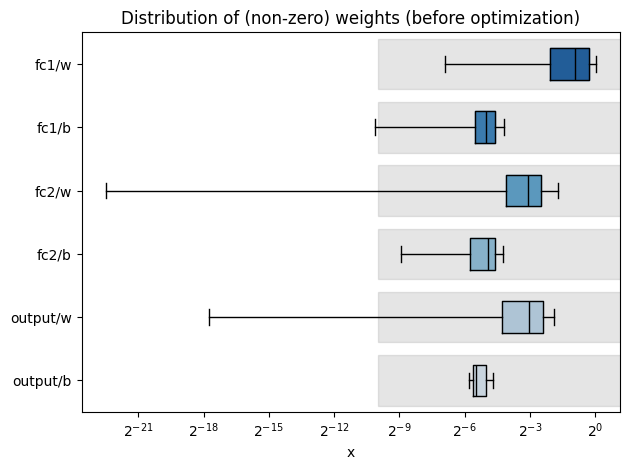

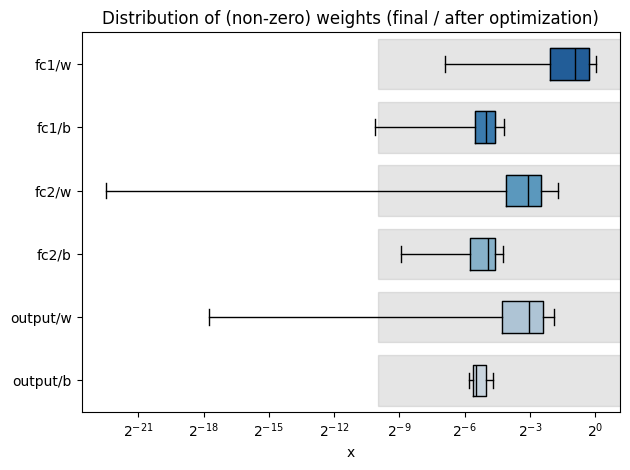

In [21]:
s_config = hls4ml.utils.config_from_keras_model(s_model, granularity='name')
hls_simple = hls4ml.converters.convert_from_keras_model(
        s_model, hls_config=s_config, output_dir=f'{model_dir}/{output_dir}/simple_model/{prj_dir}', part='xc7a35tcsg324', backend='Vivado'
    )
hls4ml.model.profiling.numerical(model=s_model, hls_model=hls_simple)

## Quantized Model

After studying the simple model, we will now qauntize it and prune it in order to maximize its performances on hardware while keeping it as light as possible. We will still use the same architecture as before, but QKeras gives as the possibility to specifcy for each layer how many bits to use for the weights, biases and activation functions. It is also possible to train the model to achieve a certain sparsity, i.e. to have a certain fraction of weights equal to zero.

Note that to express the precision of the net parameters we use a fixed point notation, e.g. `ap_fixed<16,6>` means we use W=16 total bits of which I=6 are reserved for the integer part (the sign bit is also considered) and B=W-I=10 for the fractional part. Input and output values are respectivaly encoded using `ap_fixed<16,8>` and `ap_fixed<16,3>` to achieve enough precision while stiil making the communication through UART protocol easy to handle. 

In [11]:
def create_q_model(n_in, n_out, n_hidden_layers, n_neurons, bit_kernel, bit_bias, bit_relu):
    
    # sanitize inputs
    def sanitise_input(n, array, name):
        try:
            s = len(array)
        except TypeError:
            array = np.full((n,), array, dtype=int)
            return array
        if type(array)==tuple:
            array = np.full((n,s), array, dtype=int)
            return array
        if s != n:
            raise Exception(f"Number of layers and specified values for {name} do not coincide")
        return np.array(array, dtype=int)        
    
    n_neurons  = sanitise_input(n_hidden_layers,   n_neurons,  "number of neurons")
    bit_kernel = sanitise_input(n_hidden_layers+1, bit_kernel, "kernel bits")
    bit_bias   = sanitise_input(n_hidden_layers+1, bit_bias,   "bias bits")
    bit_relu   = sanitise_input(n_hidden_layers,   bit_relu,   "relu bit")

    # construct model    
    model = Sequential()
    model.add(
        QDense(
            n_neurons[0],
            input_shape=(n_in,),
            name="fc1",
            kernel_quantizer=quantized_bits(int(bit_kernel[0][0]), int(bit_kernel[0][1]), alpha=1),
            bias_quantizer=quantized_bits(int(bit_bias[0][0]), int(bit_bias[0][1]), alpha=1),
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
        )
    )
    model.add(QActivation(activation=quantized_relu(int(bit_relu[0])), name='relu1'))
    
    for i in range(1, n_hidden_layers):
        model.add(
            QDense(
                n_neurons[i],
                name=f'fc{i+1}',
                kernel_quantizer=quantized_bits(int(bit_kernel[i][0]), int(bit_kernel[i][1]), alpha=1),
                bias_quantizer=quantized_bits(int(bit_bias[i][0]), int(bit_bias[i][1]), alpha=1),
                kernel_initializer='lecun_uniform',
                kernel_regularizer=l1(0.0001),
            )
        )
        model.add(QActivation(activation=quantized_relu(int(bit_relu[i])), name=f'relu{i+1}'))
        
    model.add(
        QDense(
            n_out,
            name='output',
            kernel_quantizer=quantized_bits(int(bit_kernel[n_hidden_layers][0]), int(bit_kernel[n_hidden_layers][1]), alpha=1),
            bias_quantizer=quantized_bits(int(bit_bias[n_hidden_layers][0]), int(bit_bias[n_hidden_layers][1]), alpha=1),
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
        )
    )
    model.add(Activation(activation='softmax', name='softmax'))
    
    return model

### Test Quantization Precision

We first test different possible precision values to see how they affect the performances of the model, both as a QKeras and as an hls model. Looking at the profiling of the simple model, we expect to need around 6 fractional bits to achieve good accuracy.

We will employ the accuracy of the model and the AUC of the ROC curve as metrics.

In [12]:
ROC_func = AUC(multi_label=True, num_labels=n_positions)

In [18]:
bit_kernel = [(2,0), (3,0), (4,0), (5,0), (6,0), (8,0), (12,0)]
bit_bias   = [(2,0), (3,0), (4,0), (5,0), (6,0), (8,0), (12,0)]
bit_relu   = [2, 3, 4, 5, 6, 8, 12]

load = True

quant_acc = np.zeros(shape=(len(bit_kernel), 2))
quant_AUC = np.zeros(shape=(len(bit_kernel), 2))

for i in range(len(bit_kernel)):  
    
    outputDir = f'{model_dir}/{output_dir}/precision_test/{i}'
    
    if load:
        Y_qkeras = np.load(f'{outputDir}/Y_qkeras.npy')
        Y_hls    = np.load(f'{outputDir}/Y_hls.npy')
        
    else:
        m = create_q_model(n_feat, n_positions, 2, 20, bit_kernel[i], bit_bias[i], bit_relu[i])
        
        ada = Adam(lr=0.0001)
        m = train_net(m, outputDir, load, 
                      X_train, Y_train, X_val, Y_val,
                      batch_size=100, opt=ada,
                      pruning=None)
    
        config = hls4ml.utils.config_from_keras_model(m, granularity='name')
        config['LayerName']['fc1_input']['Precision']['result'] = 'fixed<16,8>'
        config['LayerName']['softmax']['Precision']['result'] = 'fixed<16,3>'
        config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
        config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
        hls_m = hls4ml.converters.convert_from_keras_model(
            m, hls_config=config, output_dir=f'{outputDir}/{prj_dir}', part='xc7a35tcsg324', backend='Vivado'
        )
        hls_m.compile()
        
        Y_qkeras = m.predict(np.ascontiguousarray(X_val))
        Y_hls    = hls_m.predict(np.ascontiguousarray(X_val))
        np.save(f'{outputDir}/Y_qkeras.npy', Y_qkeras)
        np.save(f'{outputDir}/Y_hls.npy', Y_hls)
    
    quant_acc[i][0] = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(Y_qkeras, axis=1))
    quant_acc[i][1] = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(Y_hls, axis=1))
    
    ROC_func.reset_state()
    ROC_func.update_state(Y_val, Y_qkeras)
    quant_AUC[i][0] = ROC_func.result().numpy()
    ROC_func.reset_state()
    ROC_func.update_state(Y_val, Y_hls)
    quant_AUC[i][1] = ROC_func.result().numpy()

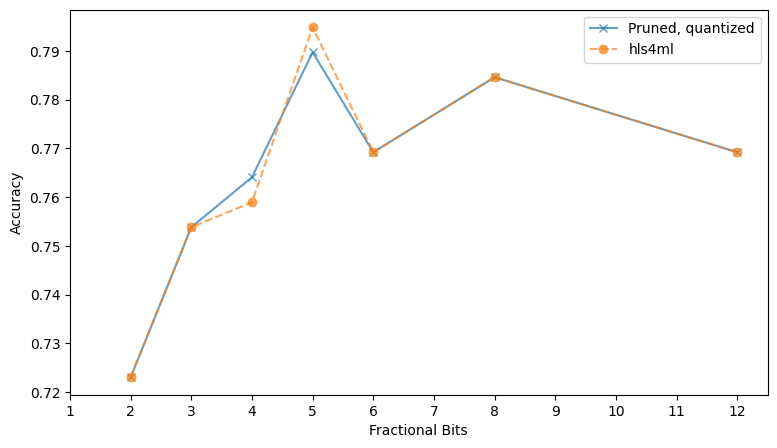

In [19]:
# PLot accuracy
fig, ax = plt.subplots(figsize=(9, 5))
x = np.array(bit_relu)
ax.plot(x, quant_acc[:,0], alpha=0.7, marker='x', label='Pruned, quantized')
ax.plot(x, quant_acc[:,1], alpha=0.7, marker='o', linestyle='--', label='hls4ml')
ax.set_xticks(np.arange(1, 13, 1))
ax.set_xlabel("Fractional Bits")
ax.set_ylabel("Accuracy")
ax.legend()

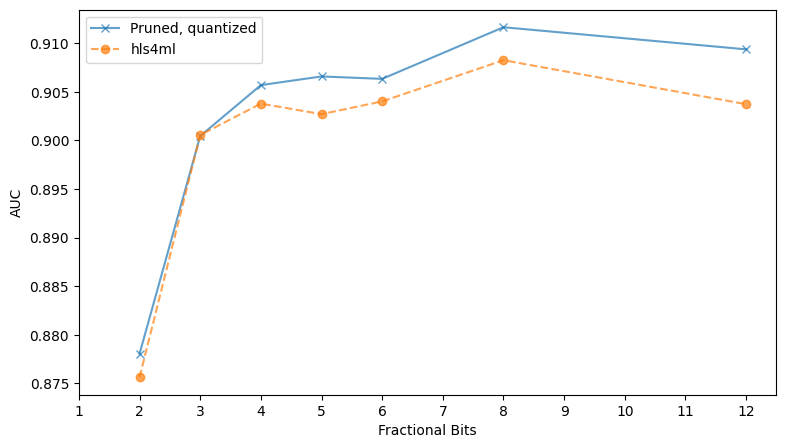

In [20]:
# PLot accuracy
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x, quant_AUC[:,0], alpha=0.7, marker='x', label='Pruned, quantized')
ax.plot(x, quant_AUC[:,1], alpha=0.7, marker='o', linestyle='--', label='hls4ml')
ax.set_xticks(np.arange(1, 13, 1))
ax.set_xlabel("Fractional Bits")
ax.set_ylabel("AUC")
ax.legend()

The results are slightly affected by the randomness of the training procedure, but nonetheless we see the expected trend: performances get better using more precision, but soon reach a plateau.

### Test Compression

After selecting the precision for the network parameters, we can check how much compression we can achieve.

In [22]:
pruning = [0.25, 0.5, 0.75, 0.9]

load = True

prun_acc = np.zeros(shape=(len(pruning), 2))
prun_AUC = np.zeros(shape=(len(pruning), 2))
ob_compr = np.zeros(shape=(len(pruning), 3))

for i in range(len(pruning)):
    
    outputDir = f'{model_dir}/{output_dir}/pruning_test/{i}'
    
    m = create_q_model(n_feat, n_positions, 2, 20, (5,0), (5,0), 5)
    
    ada = Adam(lr=0.0001)
    m = train_net(m, outputDir, load, 
                             X_train, Y_train, X_val, Y_val,
                             batch_size=100, opt=ada,
                             pruning=pruning[i])
    
    for l in range(len(m.layers)//2):
        w = m.layers[2*l].weights[0].numpy()
        ob_compr[i][l] = np.sum(w == 0) / np.size(w)
        
    if load:
        Y_qkeras = np.load(f'{outputDir}/Y_qkeras.npy')
        Y_hls    = np.load(f'{outputDir}/Y_hls.npy')
    
    else:
        config = hls4ml.utils.config_from_keras_model(m, granularity='name')
        config['LayerName']['fc1_input']['Precision']['result'] = 'fixed<16,8>'
        config['LayerName']['softmax']['Precision']['result'] = 'fixed<16,3>'
        config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
        config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
        hls_m = hls4ml.converters.convert_from_keras_model(
            m, hls_config=config, output_dir=f'{outputDir}/{prj_dir}', part='xc7a35tcsg324', backend='Vivado'
        )
        hls_m.compile()    
  
        Y_qkeras = m.predict(np.ascontiguousarray(X_val))
        Y_hls    = hls_m.predict(np.ascontiguousarray(X_val))
        np.save(f'{outputDir}/Y_qkeras.npy', Y_qkeras)
        np.save(f'{outputDir}/Y_hls.npy', Y_hls)
    
    prun_acc[i][0] = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(Y_qkeras, axis=1))
    prun_acc[i][1] = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(Y_hls, axis=1))
    
    ROC_func.reset_state()
    ROC_func.update_state(Y_val, Y_qkeras)
    prun_AUC[i][0] = ROC_func.result().numpy()
    ROC_func.reset_state()
    ROC_func.update_state(Y_val, Y_hls)
    prun_AUC[i][1] = ROC_func.result().numpy()

In [23]:
for i in range(len(pruning)):   
    print(f'Target Compression: {pruning[i]}\nAchieved Compression: Layer1={ob_compr[i][0]} - Layer2={ob_compr[i][1]} - Layer3={ob_compr[i][0]}')
    if i != len(pruning)-1:
        print('-------------------------------------------------------------')

Target Compression: 0.25
Achieved Compression: Layer1=0.25 - Layer2=0.25 - Layer3=0.25
-------------------------------------------------------------
Target Compression: 0.5
Achieved Compression: Layer1=0.5 - Layer2=0.5 - Layer3=0.5
-------------------------------------------------------------
Target Compression: 0.75
Achieved Compression: Layer1=0.75 - Layer2=0.75 - Layer3=0.75
-------------------------------------------------------------
Target Compression: 0.9
Achieved Compression: Layer1=0.9 - Layer2=0.9 - Layer3=0.9


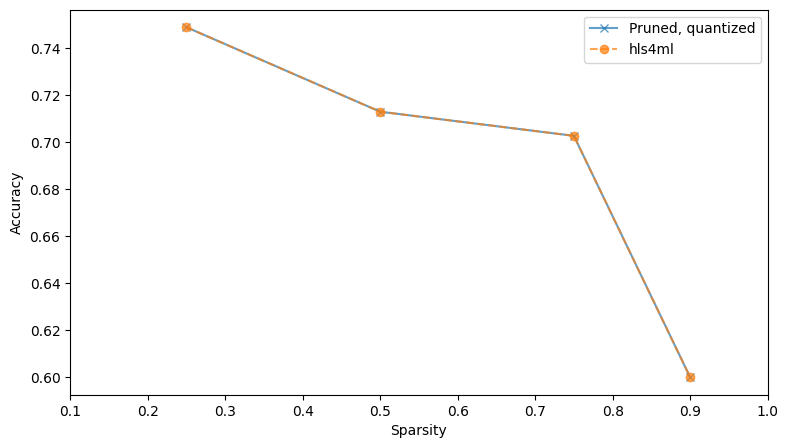

In [24]:
# PLot accuracy
fig, ax = plt.subplots(figsize=(9, 5))
x = np.array(pruning)
ax.plot(x, prun_acc[:,0], alpha=0.7, marker='x', label='Pruned, quantized')
ax.plot(x, prun_acc[:,1], alpha=0.7, marker='o', linestyle='--', label='hls4ml')
ax.set_xticks(np.arange(0.1,1.01, 0.1))
ax.set_xlabel("Sparsity")
ax.set_ylabel("Accuracy")
ax.legend()

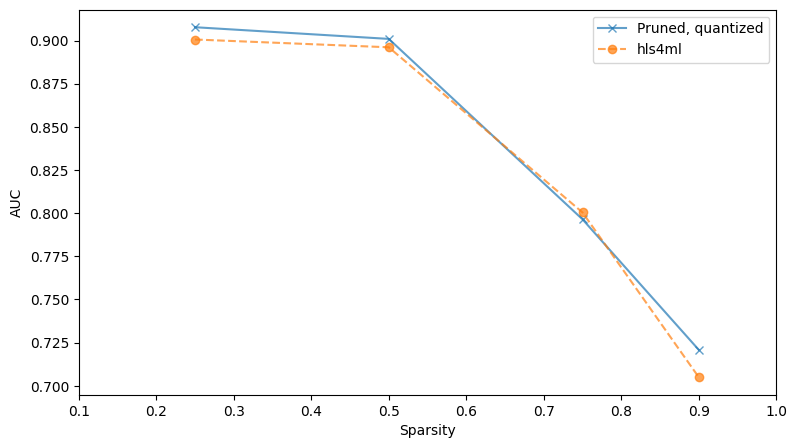

In [25]:
# PLot AUC 
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x, prun_AUC[:,0], alpha=0.7, marker='x', label='Pruned, quantized')
ax.plot(x, prun_AUC[:,1], alpha=0.7,marker='o', linestyle='--', label='hls4ml')
ax.set_xticks(np.arange(0.1,1.01, 0.1))
ax.set_xlabel("Sparsity")
ax.set_ylabel("AUC")
ax.legend()

As we can see, we reached the target compression every time. The results are still close to optimal for sparsity=0.5, and start to decline afterwards. 

### Final Model

After testing we can finally define the best model to strike a balance between accuracy and hardware efficiency. Looking at the previous plots, we choose 5 bits for the fractional part and a target sparsity of 50%.

In [26]:
best_bit_kernel = (5,0)
best_bit_bias = (5,0)
best_bit_relu = 5
best_pruning = 0.5

best_model = create_q_model(n_feat, n_positions, 2, 20, best_bit_kernel, best_bit_bias, best_bit_relu)

In [27]:
load = True

outputDir = f'{model_dir}/{output_dir}/best_model'
ada = Adam(lr=0.0001)
best_model = train_net(best_model, outputDir, load, 
                       X_train, Y_train, X_val, Y_val,
                       batch_size=100, opt=ada,
                       pruning=best_pruning)

/home/enric/miniconda3/envs/hls4ml/lib/python3.11/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc1, layer type: QDense, input shapes: [[None, 3]], output shape: [None, 20]
Layer name: relu1, layer type: Activation, input shapes: [[None, 20]], output shape: [None, 20]
Layer name: fc2, layer type: QDense, input shapes: [[None, 20]], output shape: [None, 20]
Layer name: relu2, layer type: Activation, input shapes: [[None, 20]], output shape: [None, 20]
Layer name: output, layer type: QDense, input shapes: [[None, 20]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  fc1_input
    Trace:           False
    Precision
      result:        fixed<16,8>
  fc1
    Trace:           Fal

/home/enric/miniconda3/envs/hls4ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: fc1, layer type: QDense, input shapes: [[None, 3]], output shape: [None, 20]
Layer name: relu1, layer type: Activation, input shapes: [[None, 20]], output shape: [None, 20]
Layer name: fc2, layer type: QDense, input shapes: [[None, 20]], output shape: [None, 20]
Layer name: relu2, layer type: Activation, input shapes: [[None, 20]], output shape: [None, 20]
Layer name: output, layer type: QDense, input shapes: [[None, 20]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Profiling weights (before optimization)
Profiling weights (final / after optimization)


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

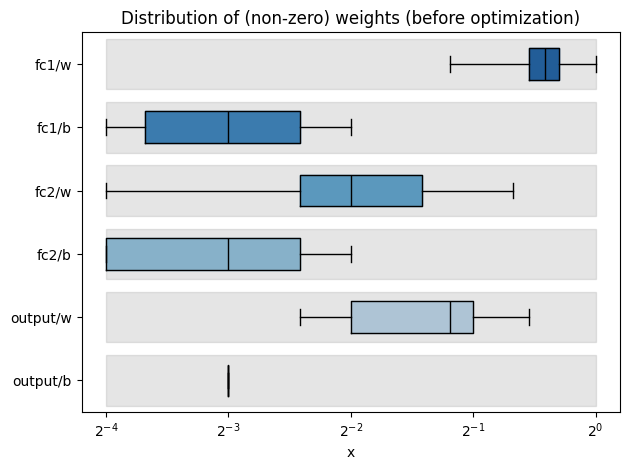

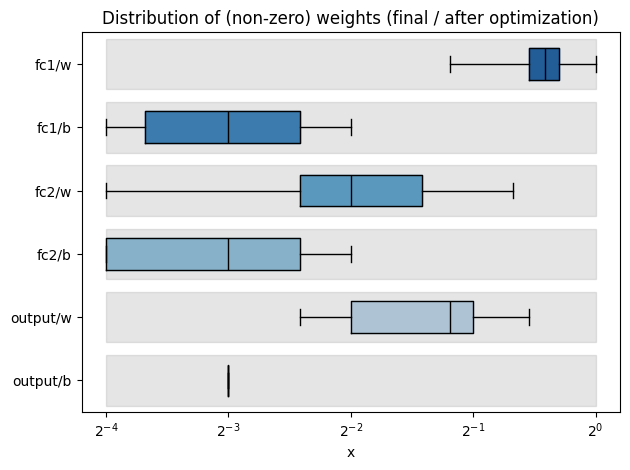

In [28]:
config = hls4ml.utils.config_from_keras_model(best_model, granularity='name')
config['LayerName']['fc1_input']['Precision']['result'] = 'fixed<16,8>'
config['LayerName']['softmax']['Precision']['result'] = 'fixed<16,3>'
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

hls_model = hls4ml.converters.convert_from_keras_model(
        best_model, hls_config=config, output_dir=f'{outputDir}/{prj_dir}', part='xc7a35tcsg324', backend='Vivado'
    )
hls_model.compile()
hls4ml.model.profiling.numerical(model=best_model, hls_model=hls_model)

Let's compare the results of this model with the reference one:

Accuracy baseline:  0.7329842931937173
Accuracy pruned, quantized: 0.7329842931937173
Accuracy hls4ml: 0.7329842931937173


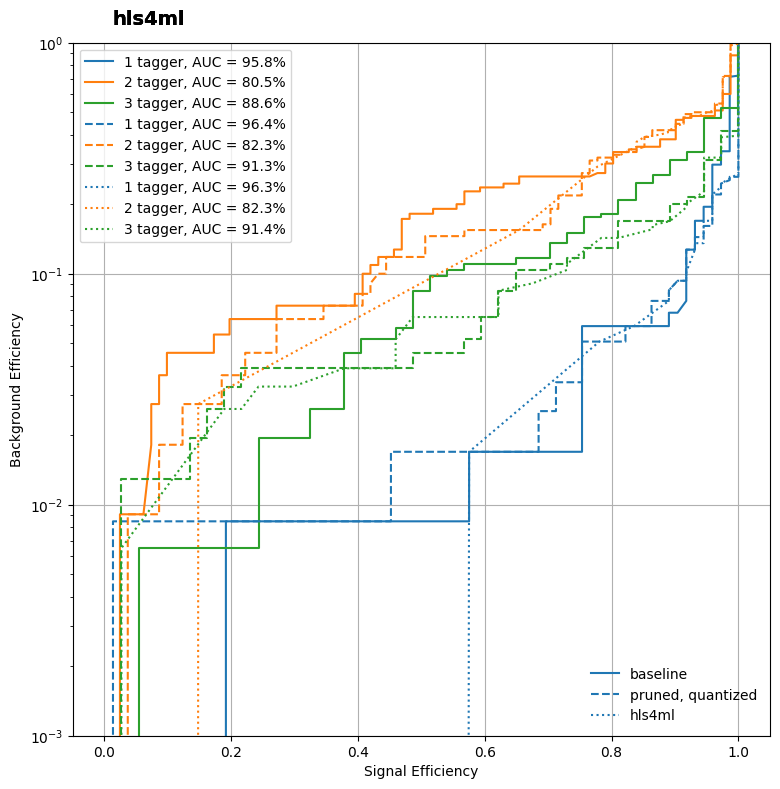

In [29]:
load = True
if load :
    Y_qkeras = np.load(f'{outputDir}/Y_qkeras.npy')
    Y_hls    = np.load(f'{outputDir}/Y_hls.npy')
else:
    Y_qkeras = best_model.predict(np.ascontiguousarray(X_test))
    Y_hls    = hls_model.predict(np.ascontiguousarray(X_test))
    np.save(f'{outputDir}/Y_qkeras.npy', Y_qkeras)
    np.save(f'{outputDir}/Y_hls.npy', Y_hls)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_simple, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(Y_test, Y_simple, ['1', '2', '3'])
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(Y_test, Y_qkeras, ['1', '2', '3'], linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(Y_test, Y_hls, ['1', '2', '3'], linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthetize the Model

The final step consists in using `Vivado HLS` to synthetize the model and obtain an IP ready to be plugged in inside the vhdl project.

In [ ]:
hls_model.build(csim=False, export=True)

In [30]:
hls4ml.report.read_vivado_report(f'{outputDir}/{prj_dir}')

Found 1 solution(s) in .//Models/best_model/hls_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sun Mar  3 22:45:54 2024

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a35t-csg324-3


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.368 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +---------+---------+---------